In [1]:
%cd ~/src/Sunrise-Demo/
from __future__ import annotations
try:
    from mediocreatbest import auto, run
except ImportError:
    %pip install --quiet --upgrade pip
    %pip install --upgrade --force-reinstall \
        mediocreatbest@git+https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git
from mediocreatbest import auto, run


/home/raustin9/src/Sunrise-Demo


/home/raustin9/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


## Setup

In [2]:
%%scope
def string_function(arr):
    name = arr.__class__.__name__
    if arr.size < 1024:
        values = auto.numpy.array_repr(auto.numpy.ravel(arr))
    else:
        values = '...'
        
    shape = auto.numpy.shape(arr)
    dtype = arr.dtype
    return f'{name}({values}, {shape=!r}, {dtype=!r})'
auto.numpy.set_string_function(string_function, repr=False)
auto.numpy.set_string_function(string_function, repr=True)

auto.numpy.set_printoptions(
    threshold=4,
    edgeitems=0,
)

### Typing

In [3]:
Degree = auto.typing.NewType('Degree', float)
Radian = auto.typing.NewType('Radian', float)
Meter = auto.typing.NewType('Meter', float)
Kilometer = auto.typing.NewType('Kilometer', float)

### Location (lat, lng, alt) to spatial (x, y, z)

In [4]:
def convert_location_to_spatial(
    *,
    lat: Degree,
    lng: Degree,
    alt: Meter,
    math=auto.math,
) -> Tuple[Meter, Meter, Meter]:
    # Thanks https://gis.stackexchange.com/a/4148
    
    #> Note that "Lat/Lon/Alt" is just another name for spherical coordinates, and 
    #> phi/theta/rho are just another name for latitude, longitude, and altitude.
    #> :) (A minor difference: altitude is usually measured from the surface of the 
    #> sphere; rho is measured from the center -- to convert, just add/subtract the 
    #> radius of the sphere.)
    phi: Radian = math.radians(lat)
    theta: Radian = math.radians(lng)
    
    # Thanks https://en.wikipedia.org/wiki/Earth_radius
    #> A globally-average value is usually considered to be 6,371 kilometres (3,959 mi)
    rho: Meter = 6_371_000 + alt
    
    #> x = math.cos(phi) * math.cos(theta) * rho
    x: Meter = math.cos(phi) * math.cos(theta) * rho
    
    #> y = math.cos(phi) * math.sin(theta) * rho
    y: Meter = math.cos(phi) * math.sin(theta) * rho

    #> z = math.sin(phi) * rho # z is 'up'
    z: Meter = math.sin(phi) * rho
    
    #> (Note there's some slightly arbitrary choices here in what each axis means...
    #> you might want 'y' to point at the north pole instead of 'z', for example.)
    
    # I do :)
    y, z = z, y
    
    return x, y, z

### Tile (zoom, x, y) to location (lat, lng)

In [5]:
@auto.mediocreatbest.doctest
def convert_tile_coordinates_to_latlng(
    *,
    z: int,
    x: int,
    y: int,
    math=auto.numpy,
    return_google_maps_url: bool=False,
) -> Tuple[Degree, Degree]:
    # r"""

    # >>> convert_tile_coordinates_to_latlng(z=15, x=8739, y=12925, return_google_maps_url=True)
    # 'https://www.google.com/maps/@35.48751102385376,-83.990478515625,15.79z?entry=ttu'

    # """
    
    # Thanks https://gis.stackexchange.com/a/133535
    
    #> n = 2 ^ zoom
    n = 2 ** z
    
    #> lon_deg = xtile / n * 360.0 - 180.0
    lon_deg = x / n * 360.0 - 180.0

    print("LATLNG")
    
    #> lat_rad = arctan(sinh(π * (1 - 2 * ytile / n)))
    lat_rad = math.arctan(math.sinh(math.pi * (1.0 - 2.0 * y / n)))
    
    #> lat_deg = lat_rad * 180.0 / π
    lat_deg = lat_rad * 180.0 / math.pi
    
    if return_google_maps_url:
        return f"""https://www.google.com/maps/@{lat_deg},{lon_deg},15.79z?entry=ttu"""
    
    return lat_deg, lon_deg

### Dataclasses

In [6]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Coord:
    """Tile image coordinates for mapbox/etc services"""
    z: int
    x: int
    y: int

    @property
    def nw(self) -> Location:
        """North-West lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=self.x,
            y=self.y,
        )
        return Location(lat=lat, lng=lng)

    @property
    def se(self) -> Location:
        """South-East lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=1+self.x,
            y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

In [7]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Domain:
    """Lower (inclusive) and upper (inclusive) bounds of latitude/longitude"""
    lo: Coord
    hi: Coord
        
    @property
    def coords(self) -> List[Coord]:
        """All coordinates within lower/upper bounds"""
        coords = []
        for z, x, y in auto.itertools.product(
            range(self.lo.z, 1+self.hi.z),
            range(self.lo.x, 1+self.hi.x),
            range(self.lo.y, 1+self.hi.y),
        ):
            coords.append(Coord(
                z=z,
                x=x,
                y=y,
            ))
        
        return coords

In [8]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Location:
    """Geographical latitude/longitude"""
    lat: Degree
    lng: Degree
    alt: Optional[Meter] = auto.dataclasses.field(default=None)

In [9]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Point:
    x: Kilometer
    y: Kilometer
    z: Kilometer

In [10]:
# @dispatch
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Tixel:
    y: int
    x: int
        
    z: ClassVar[int] = 23
        
    @property
    def location(self) -> Location:
        """Center lat/lng of current tixel"""
        lat, lng = tile_coordinates_to_latlng(
            z=1+self.z,
            x=1+self.x,
            y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

# @Tixel.register
# def __tixel_from_coord(coord: Coord, /, *, res: int):
#     dz = int(auto.math.log2(Tixel.z - coord.z))
    
    

### URL

In [11]:
@auto.dataclasses.dataclass
class TileURL:
    scheme: str
    netloc: str
    prefix: str
    z: int
    x: int
    y: int
    suffix: str
    query: Dict[str, str]
    fragment: str

    @classmethod
    @auto.mediocreatbest.doctest
    def decode(cls, url: str) -> Self:
        r"""
        
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov',
         'prefix': ['', 'styles', 'v1', 'atlas-user', 'ck58pyquo009v01p99xebegr9', 'tiles', '256'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '@2x',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov:443',
         'prefix': ['', 'v4', 'atlas-user.0000214_pink'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '.png',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        
        """
        
        scheme, netloc, path, query, fragment = auto.urllib.parse.urlsplit(
            url,
        )
        path = path.split('/')
        *prefix, z, x, suffix = path
        assert (match := auto.re.match(r'^(\d+)(.*)$', suffix)) is not None, \
            f'{suffix = !r}'
        y, suffix = match.groups()
            
        
        z, x, y = map(int, (z, x, y))
        query = auto.urllib.parse.parse_qsl(
            query,
        )

        return cls(
            scheme=scheme,
            netloc=netloc,
            prefix=prefix,
            z=z,
            x=x,
            y=y,
            suffix=suffix,
            query=query,
            fragment=fragment,
        )

    def encode(self) -> str:
        query = auto.urllib.parse.urlencode(
            self.query,
            doseq=True,
        )
        
        z, x, y = map(str, (self.z, self.x, self.y))

        path = '/'.join([
            *self.prefix,
            z,
            x,
            y + self.suffix,
        ])

        return auto.urllib.parse.urlunsplit((
            self.scheme,
            self.netloc,
            path,
            query,
            self.fragment,
        ))
    

## HTTP Request Caching

In [12]:
@run(once=True)
def cache():
    path = auto.pathlib.Path.cwd() / 'tmp' / 'Sunrise.shelve'
    return auto.shelve.open(str(path), 'c')


In [13]:
@run
def fetch(cache, /):
    def fetch(url: str, *, tqdm=None) -> bytes:
        key = url
        if key not in cache:
            if tqdm is not None:
                tqdm.set_description(f'Cache Miss: {url}')

            with auto.requests.get(url) as r:
                r.raise_for_status()
                cache[key] = r.content
            
            auto.time.sleep(1)
        
        else:
            if tqdm is not None:
                tqdm.set_description('Cache Hit: {url}')
        
        return cache[key]

    return fetch

In [14]:
def __stitch_tiles(tiles, /, size: int=128, flip=False):
    auto.PIL; from PIL import Image
    
    xs = set(tile.coord.x for tile in tiles)
    ys = set(tile.coord.y for tile in tiles)
    
    xs = sorted(xs)
    ys = sorted(ys)
    
    nx = len(xs)
    ny = len(ys)
    
    sz = size
    
    composite = Image.new('RGB', (nx*sz, ny*sz))
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        with auto.io.BytesIO(tile.image) as f:
            try:
                image = Image.open(f)
            except auto.PIL.UnidentifiedImageError:
                continue

            image.thumbnail((sz, sz))

        # composite.paste(image, (yi*sz, xi*sz))
        if flip==True:
            composite.paste(image, (yi*sz, xi*sz))
        else:
            composite.paste(image, (xi*sz, yi*sz))
            
    
    return composite

In [15]:
## @Tile.from_.register(Location)
@auto.mediocreatbest.doctest
def convert_location_to_tile(*, lat: Degree, lng: Degree, zoom: int, math=auto.math) -> tuple[int, int]:
    r"""
    
    >>> convert_location_to_tile(lat=35.6, lng=-83.52, zoom=11)
    (807, 548)
    >>> convert_location_to_tile(lat=35.0, lng=-84.5, zoom=15)
    (12979, 8692)
    >>> convert_location_to_tile(lat=36.25, lng=-82.5, zoom=15)
    (12839, 8874)
    
    """
    # Thanks https://stackoverflow.com/a/72476578
    
    #> lat_rad = math.radians(lat_deg)
    lat_rad = math.radians(lat)
    
    #> n = 2.0 ** zoom
    n = 2.0 ** zoom
    
    #> xtile = int((lon_deg + 180.0) / 360.0 * n)
    col = int((lng + 180.0) / 360.0 * n)
    
    #> ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    row = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    
    #> return (xtile, ytile)
    return row, col


# @run(scope='observation')
# def __view(interpolator, /):
#     lat, lng = (
#         (35.6201452, -83.4372325)  # Clingman's Dome
#     )
    
#     r, c = convert_location_to_tile(
#         lat=lat,
#         lng=lng,
#         zoom=Tixel.z,
#     )
#     print(f'{r=!r} {c=!r}')
    
#     k = 2
#     rs = auto.numpy.arange(r-k*128, r+k*128+1, k)
#     cs = auto.numpy.arange(c-k*128, c+k*128+1, k)
    
# #     rs, cs = interpolator.grid
    
# #     def decimate(
# #         arr: auto.numpy.ndarray,
# #         /,
# #         *,
# #         length: int,
# #     ) -> auto.numpy.ndarray:
# #         print(f'{len(arr)=!r}')
# #         stride = int(auto.math.floor( len(arr) / length ))
# #         arr = arr[::stride]
# #         arr = arr[:length]
# #         return arr
    
# #     rs = decimate(rs, length=256)
# #     cs = decimate(cs, length=256)
    
#     grid = auto.numpy.hstack(tuple(
#         v.reshape((-1, 1))
#         for v in auto.numpy.meshgrid(
#             rs,
#             cs,
#             indexing='ij',
#         )
#     ))
#     assert grid.shape == (len(rs) * len(cs), 2)
    
#     confidence = (interpolator(grid, method='linear').astype(auto.numpy.float32) * 255.0 / 4.0).astype(auto.numpy.uint8)
#     confidence = confidence.reshape((len(rs), len(cs)))
    
#     image = auto.PIL.Image.fromarray(confidence, mode='L')
    
#     auto.IPython.display.display(image)
    

## Background

In [41]:
@run(after=auto.pprint.pp, scope='background')
def domain():
    from bs4 import BeautifulSoup
    
    images = ''
    template = '<img alt="" role="presentation" src="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{x}/{y}" class="leaflet-tile leaflet-tile-loaded" style="width: 512px; height: 512px; transform: translate3d(439px, -19px, 0px); opacity: 1;">'
    zoom = 6
    for x in range((2 ** zoom)-1):
        # for y in range((2 ** zoom)-10):
        for y in range((2 ** zoom)-1):
            imgurl = template.format(z = zoom, x = x, y = y)
            images = images + imgurl
            print(imgurl)
    soup = BeautifulSoup(images, 'html.parser')
    
    # soup = BeautifulSoup(r'''
    #     <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;">
    #     <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;">
    #     <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;">
    # ''', 'html.parser')
    
    
    urls = []
    for img in soup('img'):
        src = img['src']
        url = TileURL.decode(src)
        urls.append(url)
    
    return Domain(
        lo=Coord(
            z=min(url.z for url in urls),
            x=min(url.x for url in urls),
            y=min(url.y for url in urls),
        ),
        hi=Coord(
            z=max(url.z for url in urls),
            x=max(url.x for url in urls),
            y=max(url.y for url in urls),
        ),
    )


<img alt="" role="presentation" src="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/6/0/0" class="leaflet-tile leaflet-tile-loaded" style="width: 512px; height: 512px; transform: translate3d(439px, -19px, 0px); opacity: 1;">
<img alt="" role="presentation" src="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/6/0/1" class="leaflet-tile leaflet-tile-loaded" style="width: 512px; height: 512px; transform: translate3d(439px, -19px, 0px); opacity: 1;">
<img alt="" role="presentation" src="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/6/0/2" class="leaflet-tile leaflet-tile-loaded" style="width: 512px; height: 512px; transform: translate3d(439px, -19px, 0px); opacity: 1;">
<img alt="" role="presentation" src="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/6/0/3" class="leaflet-tile leaflet-tile-loaded" style="width: 512px; height: 512px; transform: transl

In [42]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Tile:
    coord: Coord
    url: str = auto.dataclasses.field(repr=False)
    image: bytes = auto.dataclasses.field(repr=False)

@run(scope='background', after=lambda x: print(len(x)))
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        # r"""https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg"""
        r"""https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/0/0/0"""
    )):
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            # x=coord.x,
            # y=coord.y,
            x=coord.y,
            y=coord.x,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        # print(f'url: {url}')
        # print(f'coord: {coord.x}, {coord.y}')
        # print(f'url: {url}')
        image = fetch(url, tqdm=tqdm)

        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))

    return tiles

Cache Miss: https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/6/54/11:  19%|█▉        | 747/3969 [15:19<1:06:05,  1.23s/it]


KeyboardInterrupt: 

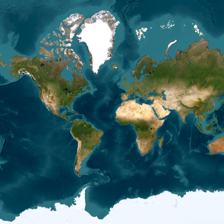

In [29]:
__stitch_tiles(run.g['background__tiles'], size=32)

In [30]:
@run(scope='background')
def interpolator(tiles, /):
    # res = 512
    res = 256
    
    zs = sorted(set(tile.coord.z for tile in tiles))
    assert len(zs) == 1
    ys = sorted(set(tile.coord.y for tile in tiles))
    xs = sorted(set(tile.coord.x for tile in tiles))
    
    print(f"""{len(ys)=!r} {len(xs)=!r}""")
    
    # This is cursed.
    points = (
        2 ** (Tixel.z - auto.math.log2(res) - zs[0]) * (auto.numpy.repeat(res * auto.numpy.array(ys)[:, None], res, axis=1) + auto.numpy.arange(res)[None, :]).ravel(),
        2 ** (Tixel.z - auto.math.log2(res) - zs[0]) * (auto.numpy.repeat(res * auto.numpy.array(xs)[:, None], res, axis=1) + auto.numpy.arange(res)[None, :]).ravel(),
    )
    
    print(f"""ys: {points[0][[0, -1]]=!r}
xs: {points[1][[0, -1]]=!r}""")
    
    values = auto.numpy.zeros(
        shape=(len(points[0]), len(points[1]), 3),
        dtype=auto.numpy.float32,
    )
    print(f"""{values.shape=!r} {values.dtype=!r}""")

    for tile in tiles:
        yi = ys.index(tile.coord.y)
        xi = xs.index(tile.coord.x)
        
        with auto.io.BytesIO(tile.image) as f:
            image = auto.PIL.Image.open(f)
            image.load()
            image = auto.PIL.ImageOps.flip(image)
            
        image = image.convert('RGB')
        image = auto.numpy.array(image, dtype=auto.numpy.float32)
        image = image[::-1,:,:]
        assert image.shape == (res, res, 3), image.shape
        assert image.dtype == auto.numpy.float32
        assert 1.0 < image.max() <= 255.0
        
        image /= 255.0
        assert 0.0 < image.max() <= 1.0
        
#         import numpy.lib.recfunctions
#         image = auto.numpy.lib.recfunctions.unstructured_to_structured(
#             image,
#             dtype=values.dtype,
#         )
#         assert image.shape == (res, res), \
#             f"""Wrong shape: {image.shape=!r}"""
#         assert image.dtype == values.dtype
        
        values[
            slice(
                (yi+0)*res,
                (yi+1)*res,
            ),
            slice(
                (xi+0)*res,
                (xi+1)*res,
            ),
        ] = image
               
    
    return auto.scipy.interpolate.RegularGridInterpolator(
        points,
        values,
    )

len(ys)=7 len(xs)=7
ys: points[0][[0, -1]]=ndarray(array([      0., 7335936.]), shape=(2,), dtype=dtype('float64'))
xs: points[1][[0, -1]]=ndarray(array([      0., 7335936.]), shape=(2,), dtype=dtype('float64'))
values.shape=(1792, 1792, 3) values.dtype=dtype('float32')


## Elevation

In [33]:
@run(scope='elevation', after=print)
# @auto.mediocreatbest.doctest
def domain(z=1):
    # z = 2
    # r'''
    # >>> domain(z=0)
    # Domain(lo=Coord(z=0, x=0, y=0), hi=Coord(z=0, x=0, y=0))
    # >>> domain(z=1)
    # Domain(lo=Coord(z=1, x=0, y=0), hi=Coord(z=1, x=1, y=1))
    # >>> domain(z=2)
    # Domain(lo=Coord(z=2, x=0, y=0), hi=Coord(z=2, x=3, y=3))
    # >>> sum(1 for _ in domain(z=0).coords)
    # 1
    # >>> sum(1 for _ in domain(z=1).coords)
    # 4
    # >>> sum(1 for _ in domain(z=2).coords)
    # 16
    # >>> sum(1 for _ in domain(z=3).coords)
    # 64
    # '''
    return Domain(
        # lo=Coord(z=11, x=546-1, y=805-1),
        # hi=Coord(z=11, x=551+1, y=808+1),
        lo=Coord(z=z, x=0, y=0),
        # hi=Coord(z=z, x=(2**z)-1, y=(2**z)-10),
        hi=Coord(z=z, x=(2**z)-1, y=(2**z)-1),
    )

@run(scope='elevation')
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://api.mapbox.com/v4/mapbox.terrain-rgb/14/3826/6127@2x.pngraw?access_token=pk.eyJ1IjoidGhvYnNvbjIiLCJhIjoiY2oxZmdqbnQzMDBpbjJxczR6dWoyemUxNiJ9.SEBHSdHLP_lZGD43r-_IDQ"""
    )) -> URL:
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image = fetch(url, tqdm=tqdm)
        
        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))
    
    return tiles

Domain(lo=Coord(z=1, x=0, y=0), hi=Coord(z=1, x=1, y=1))


Cache Hit: {url}: 100%|██████████| 4/4 [00:00<00:00, 672.43it/s]


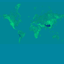

In [34]:
__stitch_tiles(auto.mediocreatbest.g['elevation__tiles'], size=32)

In [35]:
@run(scope='elevation')
def interpolator(tiles, /):
    res = 512
    
    def tile_altitude(tile: Tile, /) -> auto.numpy.NDArray[auto.numpy.float32]:
        with auto.io.BytesIO(tile.image) as f:
            image = auto.PIL.Image.open(f)
            image = auto.PIL.ImageOps.flip(image) # flip the tile vertically because we reverse the order as well
            image.load()
        
        image = image.convert('RGB')
        
        rgb = auto.numpy.array(image)
        assert len(rgb.shape) == 3, \
            f"""Expected dimension 3: {rgb.shape=!r}"""
        assert rgb.shape[0] == rgb.shape[1], \
            f"""Expected square image: {rgb.shape=!r}"""
        assert rgb.shape[0] == res, \
            f"""Expected resolution: {res}; Got resolution: {rgb.shape[0]}"""
        assert rgb.shape[2] == 3, \
            f"""Expected last component to be rgb values: {rgb.shape=!r}"""
        assert rgb.dtype == auto.numpy.uint8, \
            f"""Expected dtype to be uint8_t: {rgb.dtype=!r}"""
        
        # Thanks https://docs.mapbox.com/data/tilesets/guides/access-elevation-data/#decode-data
        #> elevation = -10000 + (({R} * 256 * 256 + {G} * 256 + {B}) * 0.1)
        
        altitude = auto.numpy.zeros(
            shape=(rgb.shape[0], rgb.shape[1]),
            dtype=auto.numpy.float32,
        )
        
        altitude += rgb[:, :, 0] * (1 * 256 * 256)
        altitude += rgb[:, :, 1] * (1 * 256)
        altitude += rgb[:, :, 2] * (1)
        altitude *= 0.1
        altitude -= 10000
        
        return altitude

    xs = sorted(set(tile.coord.x for tile in tiles))
    # Reverse sort elevation tiles on the y because for some reason they orient upside down from typical mercator proj 
    ys = sorted(set(tile.coord.y for tile in tiles))
    ys = ys[::-1]
    zs = sorted(set(tile.coord.z for tile in tiles))
    
    assert len(zs) == 1
    z ,= zs
    
    print(f'{z=!r}')
    
    dz = int(auto.math.log2(res))
    print(f'{dz=!r} {res=!r}')
    points = (
        auto.numpy.arange(
            (min(ys) + 0) * 2 ** dz,
            (max(ys) + 1) * 2 ** dz,
        ),
        auto.numpy.arange(
            (min(xs) + 0) * 2 ** dz,
            (max(xs) + 1) * 2 ** dz,
        ),
    )
    z += dz
    print(f'{z=!r}')
    
    print(f'{points[0][0]=!r}')
    print(f'{points[0][-1]=!r}')
    
    if z < Tixel.z:
        dz = Tixel.z - z
        print(f'{dz=!r}')
        points = (
            points[0] * 2 ** dz,
            points[1] * 2 ** dz,
        )
        z += dz
        print(f'{z=!r}')
        
        print(f'{points[0][0]=!r}')
        print(f'{points[0][-1]=!r}')
    
    assert z == Tixel.z
    
    values = auto.numpy.zeros(
        shape=(
            len(ys)*res,
            len(xs)*res,
        ),
        dtype=auto.numpy.float32,
    )
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        values[
            slice(
                (yi + 0) * res,
                (yi + 1) * res,
            ),
            slice(
                (xi + 0) * res,
                (xi + 1) * res,
            ),
        ] = tile_altitude(tile)

    return auto.scipy.interpolate.RegularGridInterpolator(
        points=points,
        values=values,
    )

z=1
dz=9 res=512
z=10
points[0][0]=0
points[0][-1]=1023
dz=13
z=23
points[0][0]=0
points[0][-1]=8380416


In [36]:
auto.mediocreatbest.g['elevation__interpolator']([
    auto.mediocreatbest.g['elevation__interpolator'].grid[0][100],
    auto.mediocreatbest.g['elevation__interpolator'].grid[1][100],
], method='quintic')

ndarray(array([0.], dtype=float32), shape=(1,), dtype=dtype('float32'))

## Visualize

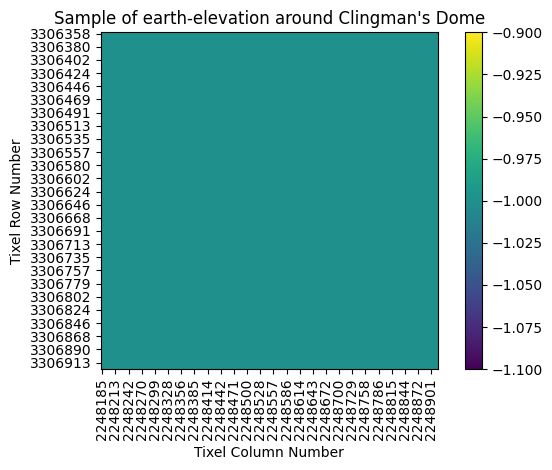

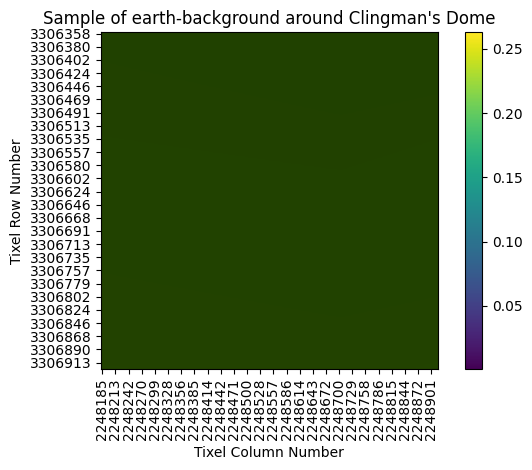

In [37]:
@run
def __visualize(elevation__interpolator, background__interpolator, /):
    def visualize(
        *,
        name: str,
        interpolator: auto.scipy.interpolate.RegularGridInterpolator,
        num: int,
    ):
        lat0, lng0 = 35.572785, -83.518351
        lat1, lng1 = 35.553081, -83.487097
        
        r0, c0 = convert_location_to_tile(
            lat=lat0,
            lng=lng0,
            zoom=Tixel.z,
        )
        
        r1, c1 = convert_location_to_tile(
            lat=lat1,
            lng=lng1,
            zoom=Tixel.z,
        )
        
        rlo, rhi = min(r0, r1), max(r0, r1)
        clo, chi = min(c0, c1), max(c0, c1)

        # real_rlo = interpolator.grid[0].min()
        # real_rhi = interpolator.grid[0].max()
        # real_clo = interpolator.grid[1].min()
        # real_chi = interpolator.grid[1].max()
        # assert rlo >= real_rlo, \
        #     f'{rlo=!r} < {real_rlo=!r}'
        # assert rhi <= real_rhi, \
        #     f'{rhi=!r} > {real_rhi=!r}'
        # assert clo >= real_clo, \
        #     f'{clo=!r} < {real_clo=!r}'
        # assert chi <= real_chi, \
        #     f'{chi=!r} > {real_chi=!r}'

    # rs = auto.numpy.arange(rlo, rhi)
    # cs = auto.numpy.arange(clo, chi)

        
        rs = auto.numpy.linspace(rlo, rhi, num=num)
        cs = auto.numpy.linspace(clo, chi, num=num)
        
        grid = auto.numpy.hstack(tuple(
            v.reshape((-1, 1))
            for v in auto.numpy.meshgrid(
                rs,
                cs,
                indexing='ij',
            )
        ))
        assert grid.shape == (len(cs)*len(rs), 2), \
            f"""Wrong shape: {grid.shape=!r}"""
        
        values = interpolator(grid)
        values = values.reshape((len(rs), len(cs), -1))
        
        %matplotlib inline
        plt = auto.matplotlib.pyplot
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = ax.imshow(values)
        ax.set_yticks(auto.numpy.arange(0, len(rs), 5))
        ax.set_yticklabels([f'{int(r)}' for r in rs[::5]], rotation=0)
        ax.set_xticks(auto.numpy.arange(0, len(cs), 5))
        ax.set_xticklabels([f'{int(c)}' for c in cs[::5]], rotation=90)
        
        ax.set_title(f"Sample of {name} around Clingman's Dome")
        ax.set_xlabel('Tixel Column Number')
        ax.set_ylabel('Tixel Row Number', rotation=90)
        
        fig.colorbar(im)
        fig.tight_layout()
        plt.show()
    
    visualize(
        name='earth-elevation',
        interpolator=elevation__interpolator,
        num=128,
    )
    
    visualize(
        name='earth-background',
        interpolator=background__interpolator,
        num=128,
    )
    

### Save

In [38]:
@run
def __save(elevation__interpolator, background__interpolator, /):
    def save(
        *,
        name: str,
        interpolator: auto.scipy.interpolate.RegularGridInterpolator,
    ):
        path = auto.pathlib.Path.cwd() / 'tmp' / f'{name}.npz'
        auto.numpy.savez_compressed(
            path,
            points0=interpolator.grid[0],
            points1=interpolator.grid[1],
            values=interpolator.values,
        )
        
        print(f'Wrote {path.stat().st_size :,d} bytes to {path}')
    
    save(
        name='earth-elevation',
        interpolator=elevation__interpolator,
    )
    
    save(
        name='earth-background',
        interpolator=background__interpolator,
    )


Wrote 406,421 bytes to /home/raustin9/src/Sunrise-Demo/tmp/earth-elevation.npz
Wrote 6,502,918 bytes to /home/raustin9/src/Sunrise-Demo/tmp/earth-background.npz
